# One For All demo

## Setting GPU

In [ ]:
!nvidia-smi

Sun Apr 17 12:34:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   3681MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download Data

In [ ]:
%cd /content
!git clone https://github.com/OFA-Sys/OFA.git

/content
fatal: destination path 'OFA' already exists and is not an empty directory.


In [ ]:
# take a little bit time
%cd /content

!mkdir -p /content/OFA/checkpoints/
!wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/checkpoints/ofa_large_clean.pt
!mv ofa_large_clean.pt OFA/checkpoints/ofa_large.pt

/content
--2022-04-17 12:34:49--  https://ofa-silicon.oss-us-west-1.aliyuncs.com/checkpoints/ofa_large_clean.pt
Resolving ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)... 47.88.111.45
Connecting to ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)|47.88.111.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6231040569 (5.8G) [application/octet-stream]
Saving to: ‘ofa_large_clean.pt’

ofa_large_clean.pt  100%[===================>]   5.80G  43.4MB/s    in 1m 54s  

2022-04-17 12:36:43 (52.1 MB/s) - ‘ofa_large_clean.pt’ saved [6231040569/6231040569]



## install library

### 

In [ ]:
# install fairseq
%cd /content
!git clone https://github.com/pytorch/fairseq.git

%cd /content/fairseq
!pip install --use-feature=in-tree-build ./

/content
fatal: destination path 'fairseq' already exists and is not an empty directory.
/content/fairseq
Processing /content/fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for fairseq: filename=fairseq-1.0.0a0+f862ff5-cp37-cp37m-linux_x86_64.whl size=16148470 sha256=d0f89acd82009a18364474c5df829fdacee7fd3e69108f2fe136273b75403c60
  Stored in directory: /tmp/pip-ephem-wheel-cache-ioiz_6kt/wheels/7c/35/80/edbd520a1a7e615df007002aeea9f6bf5f3c8f9243e072f6ce
Successfully built fairseq
  Attempting uninstall: fairseq
    Found existing installation: fairseq 1.0.0a0+f862ff5
    Uninstalling fairseq-1.0.0a0+f862ff5:
      Successfully uninstalled fairseq-1.0.0a0+f862ff5


In [ ]:
# show "requirements.txt"
reqments = open("/content/OFA/requirements.txt")
print(reqments.read())
reqments.close()

-e ./fairseq/
opencv-python
timm
ftfy==6.0.3
tensorboardX==2.4.1
pycocotools==2.0.4
pycocoevalcap==1.2
pytorch_lightning
einops
datasets
rouge_score


In [ ]:
%cd /content/OFA

!sed '1d' requirements.txt | xargs -I {} pip install {}

/content/OFA


## import libraries

In [ ]:
import torch 
import numpy as np
from fairseq import checkpoint_utils, distributed_utils, options, tasks, utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
from tasks.mm_tasks.refcoco import RefcocoTask

from models.ofa import OFAModel
from PIL import Image

import cv2
from google.colab.patches import cv2_imshow

tasks.register_task("refcoco", RefcocoTask)

# check for GPU availability
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

# specify options
parser = options.get_generation_parser()
input_args = ["", "--task=refcoco", "--beam=10", "--path=checkpoints/ofa_large.pt", "--bpe-dir=utils/BPE"]
args = options.parse_args_and_arch(parser, input_args)
cfg = convert_namespace_to_omegaconf(args)
print(parser,"\n", input_args,"\n", args, "\n", cfg)

ArgumentParser(prog='ipykernel_launcher.py', usage=None, description=None, formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True) 
 ['', '--task=refcoco', '--beam=10', '--path=checkpoints/ofa_large.pt', '--bpe-dir=utils/BPE'] 
 Namespace(aim_repo=None, aim_run_hash=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, batch_size=None, batch_size_valid=None, beam=10, best_checkpoint_metric='loss', bf16=False, bpe=None, bpe_dir='utils/BPE', broadcast_buffers=False, bucket_cap_mb=25, checkpoint_shard_count=1, checkpoint_suffix='', code_dict_size=8192, combine_valid_subsets=None, constraint_range=None, constraints=None, continue_once=None, cpu=False, cpu_offload=False, criterion='cross_entropy', curriculum=0, data='', data_buffer_size=10, dataset_impl=None, ddp_backend='pytorch_ddp', ddp_comm_hook='none', decoding_format=None, device_id=0, disable_validation=False, distributed_

# setting for building model

In [ ]:
# loading config file and pretrained model
task = tasks.setup_task(cfg.task)
models, cfg = checkpoint_utils.load_model_ensemble(
    utils.split_paths(cfg.common_eval.path),
    task=task
)

# on GPU 
for model in models:
  model.eval()
  if use_fp16:
    model.half()
  if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
    model.cuda()
  model.prepare_for_inference_(cfg)

# init generator
generator = task.build_generator(models, cfg.generation)

2022-04-17 12:37:54 | INFO | tasks.ofa_task | source dictionary: 59457 types
2022-04-17 12:37:54 | INFO | tasks.ofa_task | target dictionary: 59457 types


## Preprocess

In [ ]:
from torchvision import transforms

In [ ]:
# transform image
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((task.cfg.patch_image_size, task.cfg.patch_image_size),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# preprocess text
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()

def get_symbols_to_strip_from_output(generator):
    if hasattr(generator, "symbols_to_strip_from_output"):
        return generator.symbols_to_strip_from_output
    else:
        return {generator.bos, generator.eos}


def decode_fn(x, tgt_dict, bpe, generator, tokenizer=None):
    x = tgt_dict.string(x.int().cpu(), extra_symbols_to_ignore=get_symbols_to_strip_from_output(generator))
    token_result = []
    bin_result = []
    img_result = []
    for token in x.strip().split():
      if token.startswith('<bin_'):
        bin_result.append(token)
      elif token.startswith('<code_'):
        img_result.append(token)
      else:
        if bpe is not None:
          token = bpe.decode('{}'.format(token))
        if tokenizer is not None:
          token = tokenizer.decode(token)
        if token.startswith(' ') or len(token_result) == 0:
          token_result.append(token.strip())
        else:
          token_result[-1] += token

    return ' '.join(token_result), ' '.join(bin_result), ' '.join(img_result)

def coord2bin(coords, w_resize_ratio, h_resize_ratio):
    coord_list = [float(coord) for coord in coords.strip().split()]
    bin_list = []
    bin_list += ["<bin_{}>".format(int((coord_list[0] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[1] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[2] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[3] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    return ' '.join(bin_list)

def bin2coord(bins, w_resize_ratio, h_resize_ratio):
    bin_list = [int(bin[5:-1]) for bin in bins.strip().split()]
    coord_list = []
    coord_list += [bin_list[0] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[1] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    coord_list += [bin_list[2] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[3] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    return coord_list


def encode_text(text, length=None, append_bos=False, append_eos=False):
    line = [
      task.bpe.encode(' {}'.format(word.strip())) 
      if not word.startswith('<code_') and not word.startswith('<bin_') else word
      for word in text.strip().split()
    ]
    line = ' '.join(line)
    s = task.tgt_dict.encode_line(
        line=line,
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

def construct_sample(image: Image, instruction: str):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])

    instruction = encode_text(' {}'.format(instruction.lower().strip()), append_bos=True, append_eos=True).unsqueeze(0)
    instruction_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in instruction])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": instruction,
            "src_lengths": instruction_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        }
    }
    return sample

# function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


# Task of Visual Question Answering: VQA

## <font color="deepskyblue">get test image</font>

In [ ]:
%cd /content/OFA
!mkdir test_imgs

/content/OFA
mkdir: cannot create directory ‘test_imgs’: File exists


In [ ]:
%cd /content/OFA/test_imgs

# https://www.pakutaso.com/20180239038post-15116.html
#!wget https://www.pakutaso.com/shared/img/thumb/smIMGL4174_TP_V4.jpg
#!wget https://www.pakutaso.com/shared/img/thumb/sorasanPAR55649_TP_V4.jpg
#!wget https://external-preview.redd.it/kXPnV1mHwY1B5sVg_hC-UQE7aJl5JbQQZSuEf0BPT9s.jpg?auto=webp&s=d434b7ac9a32947b47ab131e0bdea452a08e925b
#!wget https://pbs.twimg.com/media/FD6NhBLaMAAEs4Z?format=jpg&name=900x900
#!wget https://collabo-cafe.com/wp-content/uploads/39a9dcb9289e4da659413c1aa3dcb080.jpg -O holoson_v1
#!wget https://cdn-ak.f.st-hatena.com/images/fotolife/k/konogamikono/20160910/20160910051931.jpg -O denpa_teacher
!wget https://img.atwiki.jp/aniwotawiki/attach/2878/11923/%E3%82%AB%E3%83%B3%E3%83%88%E3%83%BC%E5%BE%A1%E4%B8%89%E5%AE%B61.jpg -O pokemon

/content/OFA/test_imgs
--2022-04-17 12:38:33--  https://img.atwiki.jp/aniwotawiki/attach/2878/11923/%E3%82%AB%E3%83%B3%E3%83%88%E3%83%BC%E5%BE%A1%E4%B8%89%E5%AE%B61.jpg
Resolving img.atwiki.jp (img.atwiki.jp)... 13.224.10.78, 13.224.10.16, 13.224.10.94, ...
Connecting to img.atwiki.jp (img.atwiki.jp)|13.224.10.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205884 (201K) [image/jpeg]
Saving to: ‘pokemon’

pokemon             100%[===================>] 201.06K  --.-KB/s    in 0.02s   

2022-04-17 12:38:33 (10.6 MB/s) - ‘pokemon’ saved [205884/205884]



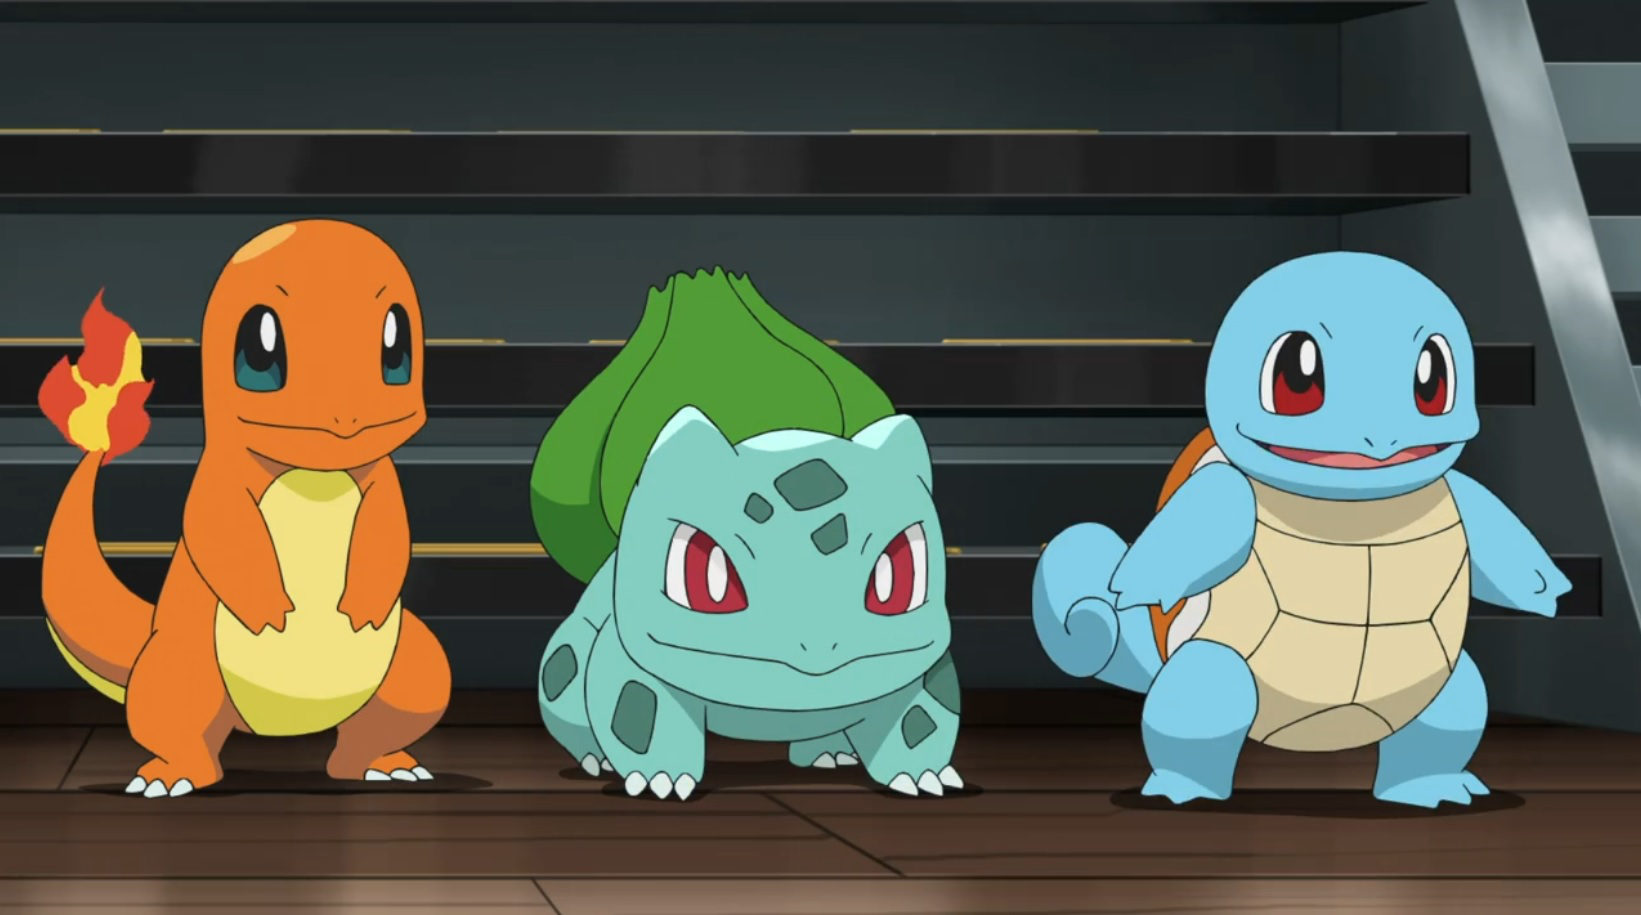

In [ ]:
#path = "/content/OFA/test_imgs/FD6NhBLaMAAEs4Z?format=jpg"
#path = "/content/OFA/test_imgs/holoson_v1"
#path = "/content/OFA/test_imgs/denpa_teacher"
path = "/content/OFA/test_imgs/pokemon"
preimage = Image.open(path)
display(preimage)
preimage.close()

In [ ]:
%cd /content/OFA
#image = Image.open("/content/OFA/test_imgs/smIMGL4174_TP_V4.jpg")
#image = Image.open("/content/OFA/test_imgs/sorasanPAR55649_TP_V4.jpg")
#image = Image.open("/content/OFA/test_imgs/FD6NhBLaMAAEs4Z?format=jpg")
image = Image.open(path)

/content/OFA


## <font color="deepskyblue">setting Question
</font>

In [ ]:
#instruction = "what does a woman have in her left hand?"
#instruction = "what does a woman have in her right hand?"
#instruction = "what color is the letter on the apron?"
#instruction = "what is the hair color of the first girl from the right ?"
#instruction = "What a man has in his left hand ?"# denpa_teacher
#instruction = "where a pokemon with flaming tail ?" #pokemon
#instruction = "where a turtle-like pokemon ?" #pokemon
instruction = "where a toad-like pokemon ?" # pokemon

In [ ]:
# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens1, bins1, imgs1 = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens2, bins2, imgs2 = decode_fn(hypos[0][1]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens3, bins3, imgs3 = decode_fn(hypos[0][2]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens4, bins4, imgs4 = decode_fn(hypos[0][3]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens5, bins5, imgs5 = decode_fn(hypos[0][4]["tokens"], task.tgt_dict, task.bpe, generator)


/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


## result

In [ ]:
# display result
#display(image)
print('Instruction: {}'.format(instruction))
print('OFA\'s Output1: {}, Probs: {}'.format(tokens1, hypos[0][0]["score"].exp().item()))
print('OFA\'s Output2: {}, Probs: {}'.format(tokens2, hypos[0][1]["score"].exp().item()))
print('OFA\'s Output3: {}, Probs: {}'.format(tokens3, hypos[0][2]["score"].exp().item()))
print('OFA\'s Output4: {}, Probs: {}'.format(tokens4, hypos[0][3]["score"].exp().item()))
print('OFA\'s Output5: {}, Probs: {}'.format(tokens5, hypos[0][4]["score"].exp().item()))


Instruction: where a toad-like pokemon ?
OFA's Output1: in the middle, Probs: 0.6863375902175903
OFA's Output2: to the left, Probs: 0.6394459009170532
OFA's Output3: on the left, Probs: 0.5683560967445374
OFA's Output4: to the right, Probs: 0.5293886065483093
OFA's Output5: middle, Probs: 0.25719717144966125


# Task of image captioning

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


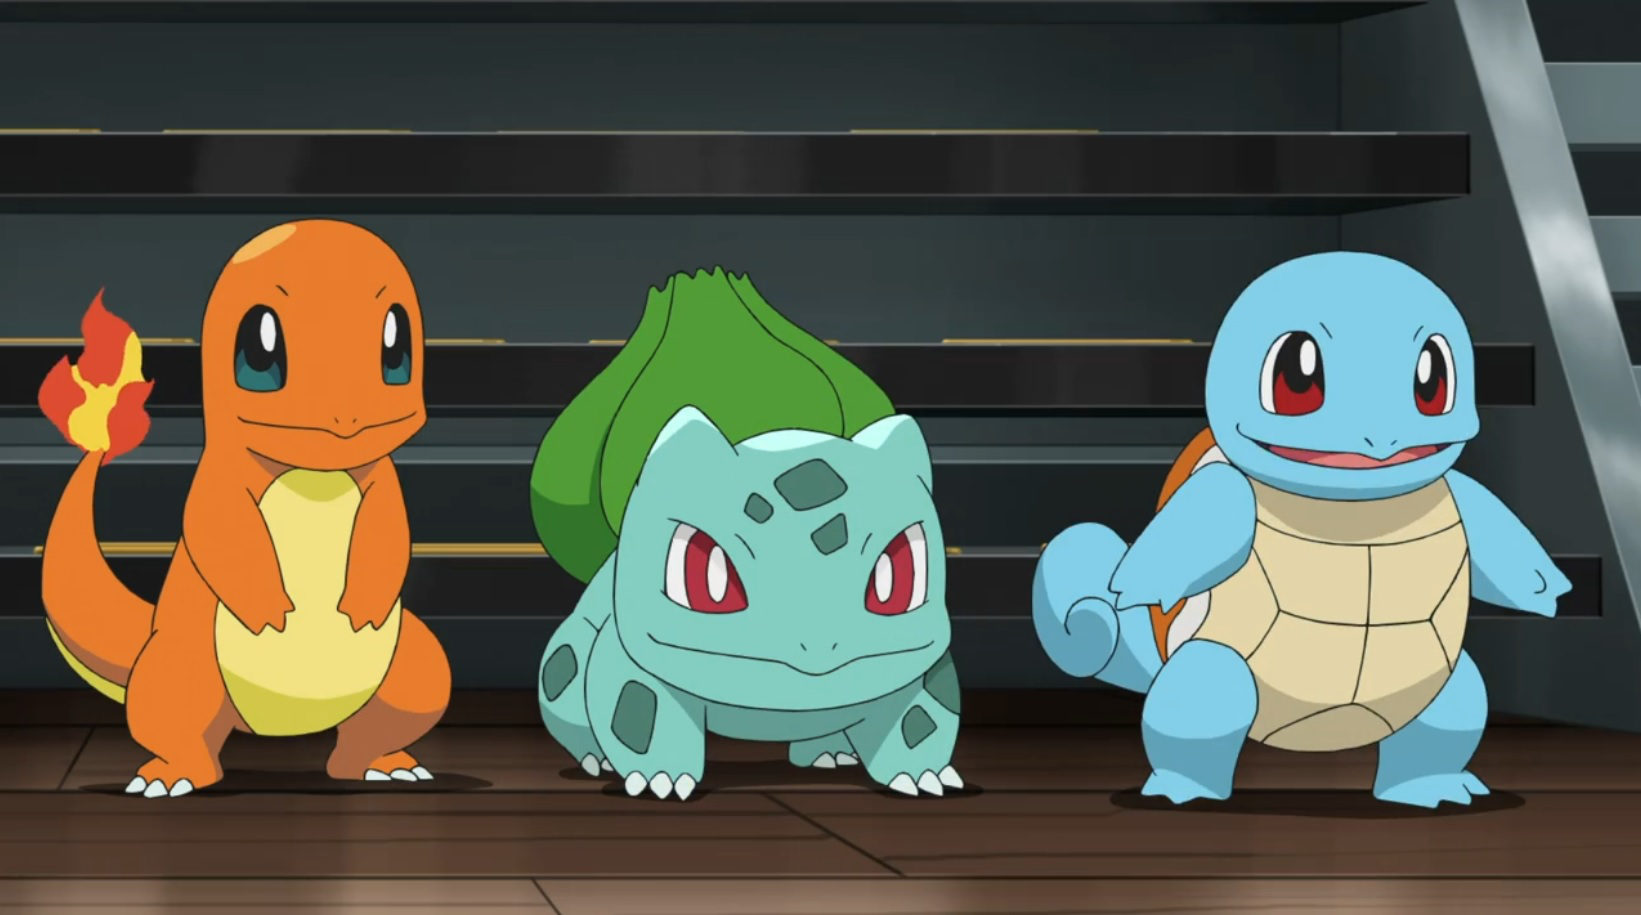

Instruction: what does the image describe?
OFA's Output1: i 've never seen a dragon in a cartoon before ., Probs: 0.3174917697906494
OFA's Output2: i 'm not sure which one of these are ., Probs: 0.30189213156700134
OFA's Output3: i 've never seen a dragon in a cartoon before, Probs: 0.28686171770095825
OFA's Output4: i 've never seen a dragon before ., Probs: 0.2857425808906555
OFA's Output5: person and animal in a match, Probs: 0.26697632670402527


In [ ]:
instruction = "what does the image describe?"

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
 
# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens1, bins1, imgs1 = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens2, bins2, imgs2 = decode_fn(hypos[0][1]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens3, bins3, imgs3 = decode_fn(hypos[0][2]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens4, bins4, imgs4 = decode_fn(hypos[0][3]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens5, bins5, imgs5 = decode_fn(hypos[0][4]["tokens"], task.tgt_dict, task.bpe, generator)
 
# display result
display(image)
print('Instruction: {}'.format(instruction))
print('OFA\'s Output1: {}, Probs: {}'.format(tokens1, hypos[0][0]["score"].exp().item()))
print('OFA\'s Output2: {}, Probs: {}'.format(tokens2, hypos[0][1]["score"].exp().item()))
print('OFA\'s Output3: {}, Probs: {}'.format(tokens3, hypos[0][2]["score"].exp().item()))
print('OFA\'s Output4: {}, Probs: {}'.format(tokens4, hypos[0][3]["score"].exp().item()))
print('OFA\'s Output5: {}, Probs: {}'.format(tokens5, hypos[0][4]["score"].exp().item()))


# Task of Grounded QA

In [ ]:
coords = "42.0 200.0 450.0 800.0" #@param {type:"string"}
w, h = image.size
w_resize_ratio = task.cfg.patch_image_size / w
h_resize_ratio = task.cfg.patch_image_size / h
bins = coord2bin(coords, w_resize_ratio, h_resize_ratio)
question = "What's in the region?" #@param {type:"string"}
instruction = "\"" + question + " region: \" + bins"

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


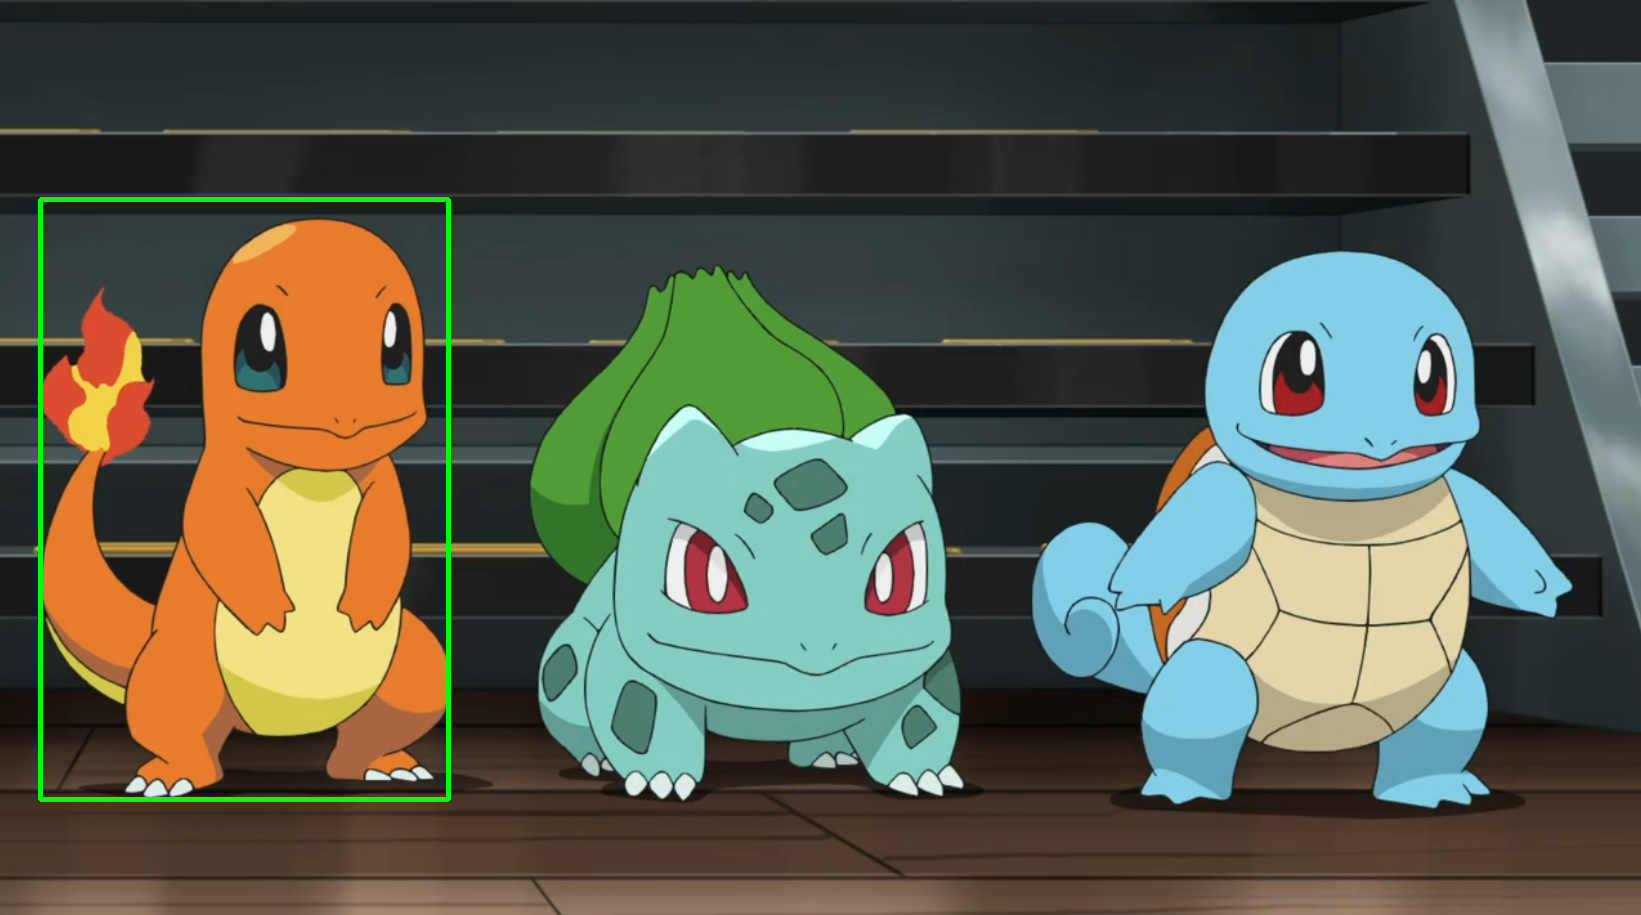

Instruction: "What's in the region? region: " + bins
OFA's Output1: a wooden bench, Probs: 0.29533571004867554
OFA's Output2: back of bench, Probs: 0.2932380735874176
OFA's Output3: a bench, Probs: 0.23795993626117706
OFA's Output4: wood, Probs: 0.19258107244968414
OFA's Output5: bench, Probs: 0.17629826068878174


In [ ]:
# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
 
# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens1, bins1, imgs1 = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens2, bins2, imgs2 = decode_fn(hypos[0][1]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens3, bins3, imgs3 = decode_fn(hypos[0][2]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens4, bins4, imgs4 = decode_fn(hypos[0][3]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens5, bins5, imgs5 = decode_fn(hypos[0][4]["tokens"], task.tgt_dict, task.bpe, generator)
 
# display result
img = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
coord_list = bin2coord(bins, w_resize_ratio, h_resize_ratio)
cv2.rectangle(
    img,
    (int(coord_list[0]), int(coord_list[1])),
    (int(coord_list[2]), int(coord_list[3])),
    (0, 255, 0),
    3
)
cv2_imshow(img)
 
print('Instruction: {}'.format(instruction))
print('OFA\'s Output1: {}, Probs: {}'.format(tokens1, hypos[0][0]["score"].exp().item()))
print('OFA\'s Output2: {}, Probs: {}'.format(tokens2, hypos[0][1]["score"].exp().item()))
print('OFA\'s Output3: {}, Probs: {}'.format(tokens3, hypos[0][2]["score"].exp().item()))
print('OFA\'s Output4: {}, Probs: {}'.format(tokens4, hypos[0][3]["score"].exp().item()))
print('OFA\'s Output5: {}, Probs: {}'.format(tokens5, hypos[0][4]["score"].exp().item()))

# Task of Visual Grounding

## <font color="deepskyblue">setting Question</font>

In [ ]:
#question = "A red dinosaur-like pokemon with a flaming tail."  #@param {type:"string"}
#question = "A green toad-like pokemon with seeds on its back." #フシギダネ
#question = "A blue turtle-like pokemon." #フシギダネ
question = "A blue turtle Pokemon standing on two legs."

instruction = 'which region does the text \" ' + question + '\" describe?'

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


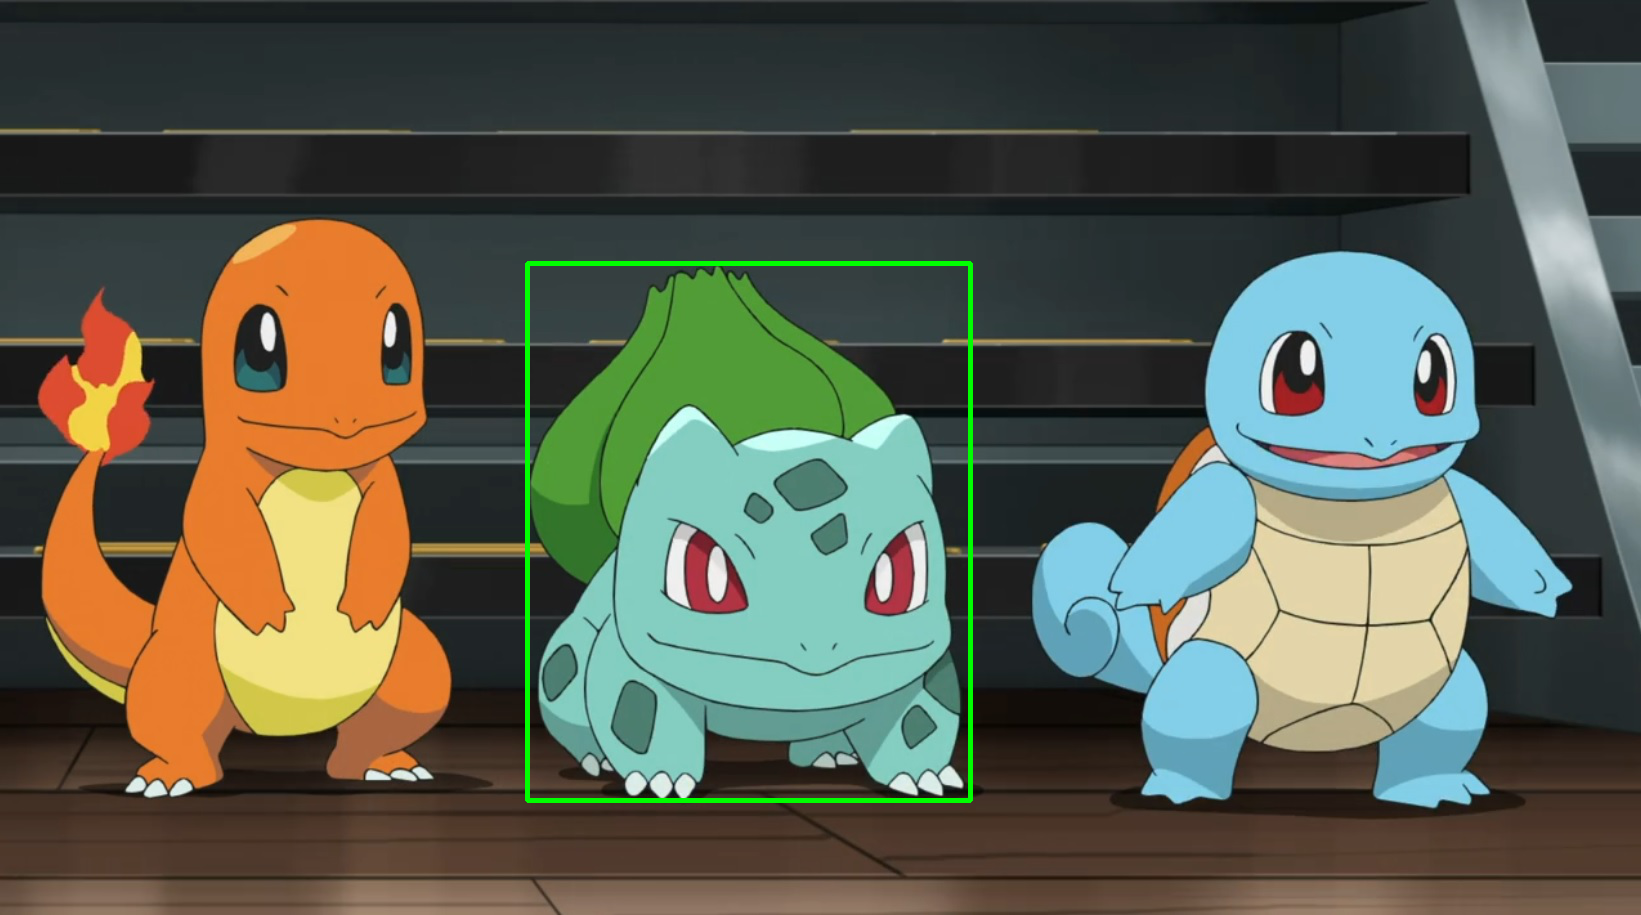

527.3977977977978 263.7837837837838 970.6922922922923 800.1441441441441


In [ ]:
# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
 
# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens, bins, imgs = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
 
# display result
w_resize_ratio = task.cfg.patch_image_size / w
h_resize_ratio = task.cfg.patch_image_size / h
img = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
coord_list = bin2coord(bins, w_resize_ratio, h_resize_ratio)
cv2.rectangle(
    img,
    (int(coord_list[0]), int(coord_list[1])),
    (int(coord_list[2]), int(coord_list[3])),
    (0, 255, 0),
    3
)
cv2_imshow(img)

print(str(coord_list[0]), str(coord_list[1]), str(coord_list[2]), str(coord_list[3]))

# must do for end

In [ ]:
image.close()

# References

1. [Visual Question Answering](https://visualqa.org/)
1. [VQA: Visual Question Answering](https://arxiv.org/pdf/1505.00468.pdf)
1. [paper with code for VQA](https://paperswithcode.com/task/visual-question-answering)
1. [UNIFYING ARCHITECTURES, TASKS, AND MODALITIES
THROUGH A SIMPLE SEQUENCE-TO-SEQUENCE LEARNING
FRAMEWORK](https://arxiv.org/pdf/2202.03052.pdf)